In [1]:
__author__ = 'Ragadeepika Pucha <rpucha@arizona.edu>, Stephanie Juneau <stephanie.juneau@noirlab.edu>'
__version__ = '20230914' 
__datasets__ = ['desi_edr'] 
__keywords__ = ['sparcl', 'spectra', 'database']

# Introduction to DESI Early Data Release (EDR) at the Astro Data Lab

*Ragadeepika Pucha (U.Arizona), Stéphanie Juneau (NOIRLab), Alice Jacques (NOIRLab), Benjamin Weaver (NOIRLab), and the Astro Data Lab Team, with contributions from Anthony Kremin (LBL), Jaime E. Forero Romero (U. de los Andes), Stephen Bailey (LBL) and the DESI Collaboration*

### Table of Contents

* [Goals & Summary](#goals)
* [Disclaimer & Attribution](#attribution)
* [Imports](#import)
* [DESI EDR Database](#desi_edr)
* [Accessing DESI Targets](#desi_target_access)
    * [Selecting Sources based on Targeting Information](#target_info)
    * [Selecting Sources in a Region of the Sky](#hpx_sel)
* [Accessing and Plotting the Spectra of a Given Object](#spectra_access)
* [References and Acknowledgements](#ref)

<a class="anchor" id="goals"></a>
# Goals

In this notebook, we will explore the DESI Early Data Release (DESI EDR) at Astro Data Lab. Namely, we show how to access the redshift catalog from the Data Lab database, how to separate objects based on the DESI targeting information, how to access all the available spectra for a given object using [SPARCL](https://astrosparcl.datalab.noirlab.edu/sparc/) (SPectra Analysis and Retrievable Catalog Lab), and finally how to plot the "best" spectrum.

# Summary

The Dark Energy Spectroscopic Instrument (DESI) is a 5000-fiber multi-object spectrograph built by the Department of Energy (DOE). It is installed on the 4-meter Mayall telescope on Kitt Peak, AZ and used to conduct a survey spanning ~14,000 deg$^2$ over 5 years (2021-2026). The DESI Early Data Release (EDR) consists of some of the commissioning data and all of the survey validation (SV) data. This includes SV1, SV2, and SV3 (the One-Percent survey), which is hosted by the Data Lab with the `desi_edr` database. More information about DESI EDR is available both from the [DESI Data Documentation website](https://data.desi.lbl.gov/doc/) and from the [Astro Data Lab DESI webpage](https://datalab.noirlab.edu/desi/).

In this notebook, we show how to access the different tables associated with this database to get targeting and redshift information regarding the targets and then use the SPARCL spectral database to retrieve the spectra.

<a class="anchor" id="attribution"></a>
# Disclaimer & Attribution
If you use this notebook for your published science, please acknowledge the following:

* Data Lab concept paper: Fitzpatrick et al., "The NOAO Data Laboratory: a conceptual overview", SPIE, 9149, 2014, http://dx.doi.org/10.1117/12.2057445

* Data Lab disclaimer: https://datalab.noirlab.edu/disclaimers.php

<a class="anchor" id="import"></a>
# Imports

In [2]:
# import some helpful python packages 
import numpy as np

from astropy.table import Table
from astropy.convolution import convolve, Gaussian1DKernel

import matplotlib 
import matplotlib.pyplot as plt

%matplotlib inline

In [3]:
# DESI targeting masks - 
from desitarget.sv1 import sv1_targetmask    # For SV1
from desitarget.sv2 import sv2_targetmask    # For SV2
from desitarget.sv3 import sv3_targetmask    # For SV3

## DataLab related modules
from sparcl.client import SparclClient
from dl import queryClient as qc

In [4]:
## Making the matplotlib plots look nicer
settings = {
    'font.size':22,
    'axes.linewidth':3.0,
    'xtick.major.size':6.0,
    'xtick.minor.size':4.0,
    'xtick.major.width':3.0,
    'xtick.minor.width':1.5,
    'xtick.direction':'in', 
    'xtick.minor.visible':True,
    'xtick.top':True,
    'ytick.major.size':6.0,
    'ytick.minor.size':4.0,
    'ytick.major.width':3.0,
    'ytick.minor.width':1.5,
    'ytick.direction':'in', 
    'ytick.minor.visible':True,
    'ytick.right':True
}

plt.rcParams.update(**settings)

In [5]:
## Load SPARCLClient
client = SparclClient()

<a class="anchor" id="desi_edr"></a>
# DESI EDR Database

The `desi_edr` database schema at DataLab consists of several tables associated with the targets.

In [6]:
print(qc.schema('desi_edr'))


Schema: desi_edr

      Table Name   Description
      ----------   -----------
        exposure   Summary quantities for every DESI exposure
     fiberassign   Quantities obtained when a DESI target is assigned to a fiber
           frame   Summary quantities for each petal of the DESI instrument i
                   n a given exposure; in normal operation there are ten fram
                   es for every exposure
      photometry   Photometric quantities from LS DR9 for every TARGETID
       potential   For a given tile, this table lists all targets that could 
                   have received a fiber assignment
          target   The quantities obtained when photometric objects are analy
                   zed in the target selection process
            tile   Summary quantities for every DESI tile (pointing on the sky)
x1p5__zpix__allwise__source   desi_edr.zpix and xmatch_std.allwise__source crossmatch (1
                   .5 arcsec)
x1p5__zpix__gaia_dr3__gaia_source   desi_edr

We will focus on the `zpix` table in this notebook. This is the main redshift catalog from the DESI survey. It contains the redshift information from the coadded-spectra, based on the healpix of the objects. It also contains the targeting information of the different sources.

We look at the available columns in this table below.

In [7]:
## Columns in the zpix table
print(qc.schema('desi_edr.zpix'))


Schema: desi_edr
 Table: zpix

     Column Name   Description
     -----------   -----------
               z   Redshift measured by Redrock
            zerr   Redshift error from Redrock
            chi2   Best fit chi squared
         coeff_0   Redrock template coefficients
         coeff_1   Redrock template coefficients
         coeff_2   Redrock template coefficients
         coeff_3   Redrock template coefficients
         coeff_4   Redrock template coefficients
         coeff_5   Redrock template coefficients
         coeff_6   Redrock template coefficients
         coeff_7   Redrock template coefficients
         coeff_8   Redrock template coefficients
         coeff_9   Redrock template coefficients
       deltachi2   Delta-chi-squared for template fit from Redrock
   mean_fiber_ra   Mean (over exposures) RA of actual fiber position
  mean_fiber_dec   Mean (over exposures) DEC of actual fiber position
            elon   Ecliptic longitude
            elat   Ecliptic latitude


<a class="anchor" id="desi_target_access"></a>
# Accessing DESI Targets

The DESI spectra are uniquely identified by three quantities:

* **targetid**: unique identifier for a given target
* **survey**: SURVEY that the target was observed in. This can be _cmx_, _special_, _sv1_, _sv2_, or _sv3_.
* **program**: FIBER ASSIGNMENT PROGRAM. This is the planned observing conditions for the target. It can be _dark_ or _bright_ or _backup_. In case of cmx and sv1, there is _other_ as well.
    
The different spectra observations of individual targets are coadded within each survey and program. Therefore, some targets may have multiple coadded spectra and each one is associated with a given `targetid`, `survey`, and `program`. The "best" spectrum for a given object is given by the `zcat_primary` column. More information about the data model of the redshift catalogs is available [here](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html#).

In [8]:
query = """
SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
       CAST(zp.zcat_primary AS INT), zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
FROM desi_edr.zpix AS zp
""" 

## Information about the query
## Selected columns --
## targetid, survey, program -- unique identifiers for a given spectrum
## healpix -- healpix number for the target
## z -- spectroscopic redshift of the target
## zwarn -- encoded information regarding the redshift (zwarn = 0 is good)
## coadd_fiberstatus -- encoded information regarding the fiber that is assigned to the target (coadd_fiberstatus = 0 is good)
## spectype -- Spectral type of the target: STAR | GALAXY | QSO
## mean_fiber_ra, mean_fiber_dec -- Mean R.A. and Dec. of the fiber position from all the observations of the target
## zcat_nspec -- Number of coadded spectra that are available for a given target
## zcat_primary -- Whether or not a given coadded spectra is the primary spectra. ZCAT_PRIMARY = True for the "best" spectrum.
## CASTing this column as an INT: ZCAT_PRIMARY = 1 for the "best" spectrum.
## desi_target -- encodeds main survey's desi targeting information - explained in detail below
## sv1_desi_target -- encodes sv1 desi targeting information
## sv2_desi_target -- encodes sv2 desi targeting information
## sv3_desi_target -- encodes sv3 desi targeting information

In [9]:
print(query)


SELECT zp.targetid, zp.survey, zp.program, zp.healpix,  
       zp.z, zp.zwarn, zp.coadd_fiberstatus, zp.spectype, 
       zp.mean_fiber_ra, zp.mean_fiber_dec, zp.zcat_nspec, 
       CAST(zp.zcat_primary AS INT), zp.desi_target,
       zp.sv1_desi_target, zp.sv2_desi_target, zp.sv3_desi_target
FROM desi_edr.zpix AS zp



In [10]:
zpix = qc.query(sql = query, fmt = 'table')

In [11]:
print(f"The resulting table has {len(zpix)} rows")
zpix[0:5]

The resulting table has 2044588 rows


targetid,survey,program,healpix,z,zwarn,coadd_fiberstatus,spectype,mean_fiber_ra,mean_fiber_dec,zcat_nspec,zcat_primary,desi_target,sv1_desi_target,sv2_desi_target,sv3_desi_target
int64,str7,str6,int64,float64,int64,int64,str6,float64,float64,int64,int64,int64,int64,int64,int64
39633414185291967,sv3,dark,15341,0.6555981990098714,0,0,GALAXY,273.42926,62.27449,1,1,0,0,0,8457
39633414185291844,sv3,bright,15341,0.026610786749721827,0,0,GALAXY,273.41397,62.304092,1,1,0,0,0,5764607523034234880
39633414185291911,sv3,bright,15341,0.1815527832416608,0,0,GALAXY,273.42245,62.34335,1,1,0,0,0,1152921504606846976
39633414185291937,sv3,dark,15341,0.8321858435838179,0,0,GALAXY,273.4253,62.346302,1,1,0,0,0,8457
39633416995473409,sv3,dark,15352,0.6739049813320204,4,0,GALAXY,273.4549,62.377106,1,1,0,0,0,4611686018427388932


In [12]:
# Check how many rows have unique TARGETIDs before/after applying the ZCAT_PRIMARY flag
print(f"Total N(rows) : {len(zpix)}")
print(f"N(rows) with unique TARGETIDs : {len(np.unique(zpix['targetid']))}")

is_primary = zpix['zcat_primary']==1

print(f"N(rows) with ZCAT_PRIMARY=True : {len(zpix[is_primary])}")

Total N(rows) : 2044588
N(rows) with unique TARGETIDs : 1979269
N(rows) with ZCAT_PRIMARY=True : 1979269


In [13]:
## Selecting only unique objects
zpix_cat = zpix[is_primary]

<a class="anchor" id="target_info"></a>
## Selecting Sources based on Targeting Information

DESI targets are divided into five main classes:
* MWS: Milky Way Survey - This survey probes "stars" in the Milky Way.
* BGS: Bright Galaxy Survey - This survey probes the bright galaxies in the nearby universe.
* LRG: Luminous Red Galaxies
* ELG: Emission Line Galaxies
* QSO: Quasars

[Myers et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract) describes the target selection and information in more detail.

The `*DESI_TARGET` columns encode the information related to which class the target belongs to. Note that some sources can be part of different classes. <br/>
In this section, we show how to select sources based on their targeting information.

The targetmasks contain the bit information regarding the different targeting classes. <br/>
Apart from these main classes, there are targets that are part of secondary-fiber proposal programs. These targets are encoded under `SECONDARY PROGRAM`.

In [14]:
# Targeting bits are coded in the sv*_targetmask.desi_mask
sv1_targetmask.desi_mask

sv1_desi_mask:
  - [LRG,              0, "LRG", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}, 'numobs': 2}]
  - [ELG,              1, "ELG", {'obsconditions': 'DARK|GRAY', 'priorities': {'UNOBS': 3000, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3000, 'MORE_ZGOOD': 3000}, 'numobs': 1}]
  - [QSO,              2, "QSO", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3400, 'MORE_ZGOOD': 3350, 'MORE_ZWARN': 3300, 'MORE_MIDZQSO': 100, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0}, 'numobs': 4}]
  - [LRG_OPT,          3, "LRG from baseline version of optical cuts", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MORE_ZGOOD': 3200}, 'numobs': 4}]
  - [LRG_IR,           4, "LRG from baseline version of IR cuts", {'obsconditions': 'DARK', 'priorities': {'UNOBS': 3200, 'DONE': 2, 'OBS': 1, 'DONOTOBSERVE': 0, 'MORE_ZWARN': 3200, 'MO

In [15]:
# A few example bitmask values

print(sv1_targetmask.desi_mask.mask("STD_FAINT"), sv1_targetmask.desi_mask.mask("STD_BRIGHT"), sv1_targetmask.desi_mask.mask("STD_FAINT|STD_BRIGHT"))
print(2**33, 2**35, 2**33 + 2**35)

8589934592 34359738368 42949672960
8589934592 34359738368 42949672960


In [16]:
# Targeting information about the DESI targeting is stored in the different desi_target columns
# sv1_targetmask.desi_mask corresponds to SV1_DESI_TARGET
# sv2_targetmask.desi_mask corresponds to SV2_DESI_TARGET
# sv3_targetmask.desi_mask corresponds to SV3_DESI_TARGET

sv1_desi_tgt = zpix_cat['sv1_desi_target']
sv2_desi_tgt = zpix_cat['sv2_desi_target']
sv3_desi_tgt = zpix_cat['sv3_desi_target']

## DESI Bitmasks
sv1_desi_mask = sv1_targetmask.desi_mask
sv2_desi_mask = sv2_targetmask.desi_mask
sv3_desi_mask = sv3_targetmask.desi_mask

In [17]:
# Selecting candidates - 

is_bgs = (sv1_desi_tgt & sv1_desi_mask['BGS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['BGS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['BGS_ANY'] != 0)
is_lrg = (sv1_desi_tgt & sv1_desi_mask['LRG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['LRG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['LRG'] != 0)
is_elg = (sv1_desi_tgt & sv1_desi_mask['ELG'] != 0)|(sv2_desi_tgt & sv2_desi_mask['ELG'] != 0)|(sv3_desi_tgt & sv3_desi_mask['ELG'] != 0)
is_qso = (sv1_desi_tgt & sv1_desi_mask['QSO'] != 0)|(sv2_desi_tgt & sv2_desi_mask['QSO'] != 0)|(sv3_desi_tgt & sv3_desi_mask['QSO'] != 0)
is_mws = (sv1_desi_tgt & sv1_desi_mask['MWS_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['MWS_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['MWS_ANY'] != 0)
is_scnd = (sv1_desi_tgt & sv1_desi_mask['SCND_ANY'] != 0)|(sv2_desi_tgt & sv2_desi_mask['SCND_ANY'] != 0)|(sv3_desi_tgt & sv3_desi_mask['SCND_ANY'] != 0)

In [18]:
# Number of sources of each target type
n_bgs = len(zpix_cat[is_bgs])
n_lrg = len(zpix_cat[is_lrg])
n_elg = len(zpix_cat[is_elg])
n_qso = len(zpix_cat[is_qso])
n_mws = len(zpix_cat[is_mws])
n_scnd = len(zpix_cat[is_scnd])

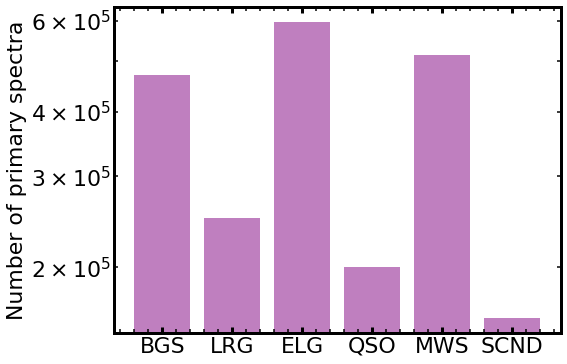

In [19]:
# Let us look at the numbers visually - 

plt.figure(figsize = (8,6))

targets = ['BGS', 'LRG', 'ELG', 'QSO', 'MWS', 'SCND']
numbers = [n_bgs, n_lrg, n_elg, n_qso, n_mws, n_scnd]

plt.bar(targets, numbers, color = 'purple', alpha = 0.5)
plt.ylabel('Number of primary spectra')
plt.yscale('log')

Text(0.5, 0, 'Redshift')

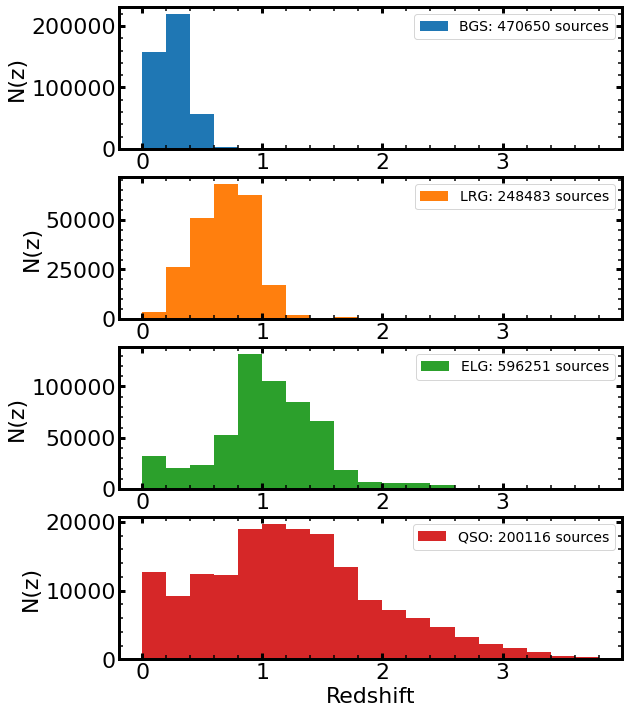

In [20]:
# Now let us look at the distribution of redshifts -

fig, axs = plt.subplots(4, 1, figsize = (9, 12))
bins = np.arange(0, 4, 0.2)

axs[0].hist(zpix_cat['z'][is_bgs], color = 'C0', bins = bins, label = f'BGS: {n_bgs} sources')
axs[0].legend(fontsize = 14)
axs[0].set_ylabel("N(z)")
axs[1].hist(zpix_cat['z'][is_lrg], color = 'C1', bins = bins, label = f'LRG: {n_lrg} sources')
axs[1].legend(fontsize = 14)
axs[1].set_ylabel("N(z)")
axs[2].hist(zpix_cat['z'][is_elg], color = 'C2', bins = bins, label = f'ELG: {n_elg} sources')
axs[2].legend(fontsize = 14)
axs[2].set_ylabel("N(z)")
axs[3].hist(zpix_cat['z'][is_qso], color = 'C3', bins = bins, label = f'QSO: {n_qso} sources')
axs[3].legend(fontsize = 14)
axs[3].set_ylabel("N(z)")
axs[3].set_xlabel("Redshift")


### Other masks

`desi_mask` consists of the uppermost level targeting information in DESI. However, there are sub-classes of targets. <br/>
For example, BGS have different target masks depending on the selection criterion. Each of the different secondary target proposals have their own masks. They can be selected in a similar way as above, but with the respective columns (like `SV1_BGS_TARGET` or `SV1_SCND_TARGET`) in the `target` table. More information about Bitmasks in DESI is available [here](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html).

In [21]:
## BGS Target Masks
sv1_targetmask.bgs_mask.names()

['BGS_FAINT',
 'BGS_BRIGHT',
 'BGS_FAINT_EXT',
 'BGS_LOWQ',
 'BGS_FIBMAG',
 'BGS_FAINT_NORTH',
 'BGS_BRIGHT_NORTH',
 'BGS_FAINT_EXT_NORTH',
 'BGS_LOWQ_NORTH',
 'BGS_FIBMAG_NORTH',
 'BGS_FAINT_SOUTH',
 'BGS_BRIGHT_SOUTH',
 'BGS_FAINT_EXT_SOUTH',
 'BGS_LOWQ_SOUTH',
 'BGS_FIBMAG_SOUTH',
 'BGS_KNOWN_ANY',
 'BGS_KNOWN_COLLIDED',
 'BGS_KNOWN_SDSS',
 'BGS_KNOWN_BOSS']

In [22]:
## Secondary Target Masks
sv1_targetmask.scnd_mask.names()

['VETO',
 'UDG',
 'FIRST_MALS',
 'QSO_RED',
 'M31_KNOWN',
 'M31_QSO',
 'M31_STAR',
 'MWS_CLUS_GAL_DEEP',
 'LOW_MASS_AGN',
 'FAINT_HPM',
 'PV_BRIGHT',
 'PV_DARK',
 'LOW_Z',
 'BHB',
 'SPCV',
 'DC3R2_GAMA',
 'UNWISE_BLUE',
 'UNWISE_GREEN',
 'HETDEX_MAIN',
 'HETDEX_HP',
 'PSF_OUT_BRIGHT',
 'PSF_OUT_DARK',
 'HPM_SOUM',
 'SN_HOSTS',
 'GAL_CLUS_BCG',
 'GAL_CLUS_2ND',
 'GAL_CLUS_SAT',
 'HSC_HIZ_SNE',
 'ISM_CGM_QGP',
 'STRONG_LENS',
 'WISE_VAR_QSO',
 'MWS_CALIB',
 'BACKUP_CALIB',
 'MWS_MAIN_CLUSTER_SV',
 'MWS_RRLYR',
 'BRIGHT_HPM',
 'WD_BINARIES_BRIGHT',
 'WD_BINARIES_DARK',
 'LBG_TOMOG_XMM',
 'LBG_TOMOG_W3',
 'UNWISE_GREEN_II_3700',
 'UNWISE_GREEN_II_3800',
 'UNWISE_GREEN_II_3900',
 'UNWISE_GREEN_II_4000',
 'UNWISE_BLUE_FAINT_II',
 'UNWISE_BLUE_BRIGHT_II',
 'DESILBG_TMG_FINAL',
 'DESILBG_G_FINAL',
 'DESILBG_BXU_FINAL',
 'LBG_TOMOG_COSMOS_FINAL',
 'BRIGHT_TOO',
 'DARK_TOO']

<a class="anchor" id="hpx_sel"></a>
## Selecting Sources in a Region of the Sky

The targets are divided into different healpix regions on the sky. Here we select all the targets in a given healpix region. <br/>
We also overplot the `Milky Way Survey` targets in this region.

In [23]:
hpx = 26279      

sel = (zpix_cat['healpix'] == hpx)
tsel = zpix_cat[sel]

In [24]:
## Selecting MWS sources in this regions
is_mws = (tsel['sv1_desi_target'] & sv1_targetmask.desi_mask['MWS_ANY'] != 0)|(tsel['sv2_desi_target'] & sv2_targetmask.desi_mask['MWS_ANY'] != 0)|(tsel['sv3_desi_target'] & sv3_targetmask.desi_mask['MWS_ANY'] != 0)

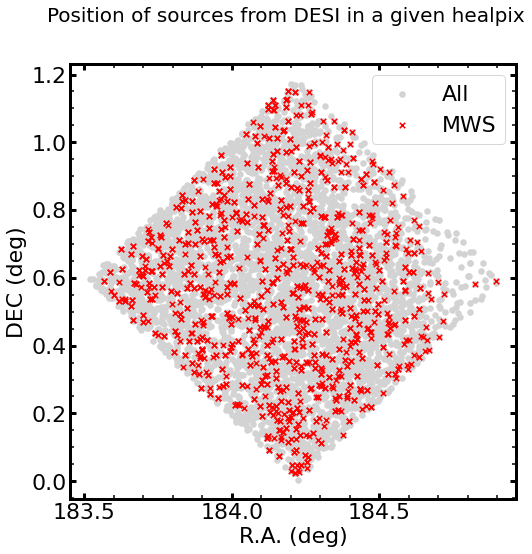

In [25]:
plt.figure(figsize = (8, 8))

plt.suptitle('Position of sources from DESI in a given healpix', fontsize = 20)
plt.scatter(tsel['mean_fiber_ra'], tsel['mean_fiber_dec'], color = 'lightgrey', s = 30, label = 'All')
plt.scatter(tsel['mean_fiber_ra'][is_mws], tsel['mean_fiber_dec'][is_mws], color = 'r', s = 30, marker = 'x', label = 'MWS')
plt.xlabel('R.A. (deg)')
plt.ylabel('DEC (deg)')
plt.legend()

<a class="anchor" id="spectra_access"></a>
# Accessing and Plotting the Spectra of a Given Object

Finally, we show how to access all the available healpix-coadded spectra of a given object. We also show how to select the "best" spectrum. <br/>
We use SPARCL, which is a fast spectral access service at Data Lab. <br/>
Detailed ways to using SPARCL are available in this [notebook](https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/How_to_use_SPARCL.ipynb).

In [26]:
## Select STAR with nspec > 3
jj = (zpix_cat['zcat_nspec'] > 3)&(zpix_cat['spectype'] == 'STAR')
tsel = zpix_cat[jj]

In [27]:
len(tsel)

308

In [28]:
## Randomly select an object

ii = 50
targetid = int(tsel['targetid'].data[ii])   ## SPARCL accepts only python integers

In [29]:
## Retrieve Spectra

inc = ['specid', 'redshift', 'flux', 'wavelength', 'spectype', 'specprimary', 'survey', 'program', 'targetid', 'coadd_fiberstatus']
res = client.retrieve_by_specid(specid_list = [targetid],
                                include = inc,
                                dataset_list = ['DESI-EDR'])

In [30]:
## Checking that all the different spectra are retrieved

print ('Number of coadded spectra: ', tsel['zcat_nspec'].data[ii])
print ('Number of retrieved records: ', len(res.records))

Number of coadded spectra:  4
Number of retrieved records:  4


In [31]:
res

Retrieved Results: 4 records

In [32]:
records = res.records

## Select the primary spectrum
spec_primary = np.array([records[jj].specprimary for jj in range(len(records))])

primary_ii = np.where(spec_primary == True)[0][0]

In [33]:
lam_primary = records[primary_ii].wavelength
flam_primary = records[primary_ii].flux

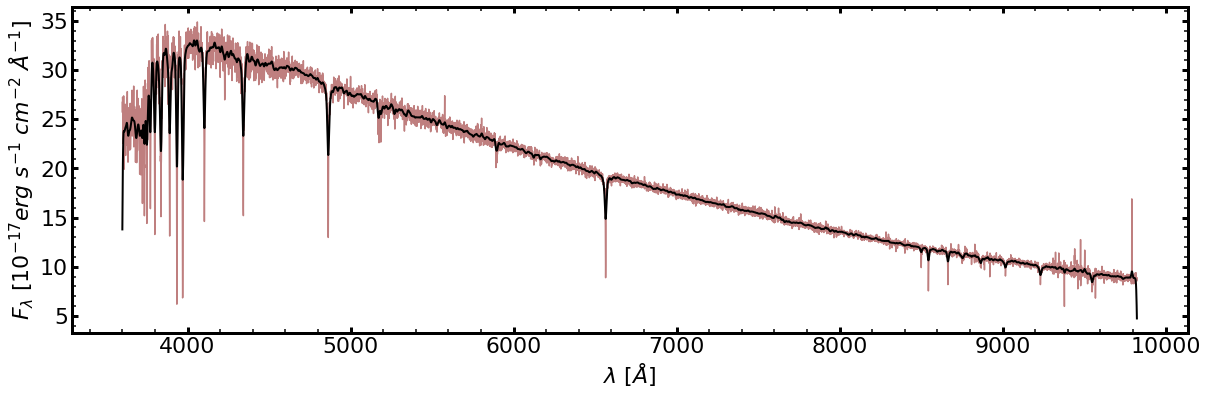

In [34]:
# Plotting this spectra -

plt.figure(figsize = (20, 6))
# Plot the spectrum from each arm (B,R,Z) in blue, green, red

plt.plot(lam_primary, flam_primary, color = 'maroon', alpha = 0.5)
# Over-plotting smoothed spectra in black 
plt.plot(lam_primary, convolve(flam_primary, Gaussian1DKernel(5)), color = 'k', lw = 2.0)
plt.xlabel('$\lambda$ [$\AA$]')
plt.ylabel('$F_{\lambda}$ [$10^{-17} erg\ s^{-1}\ cm^{-2}\ \AA^{-1}$]')
plt.show()

Let us now plot all the available spectra available for this object. <br/>
In each case, the `survey`, `program` and the `primary` flag is mentioned with the spectra.

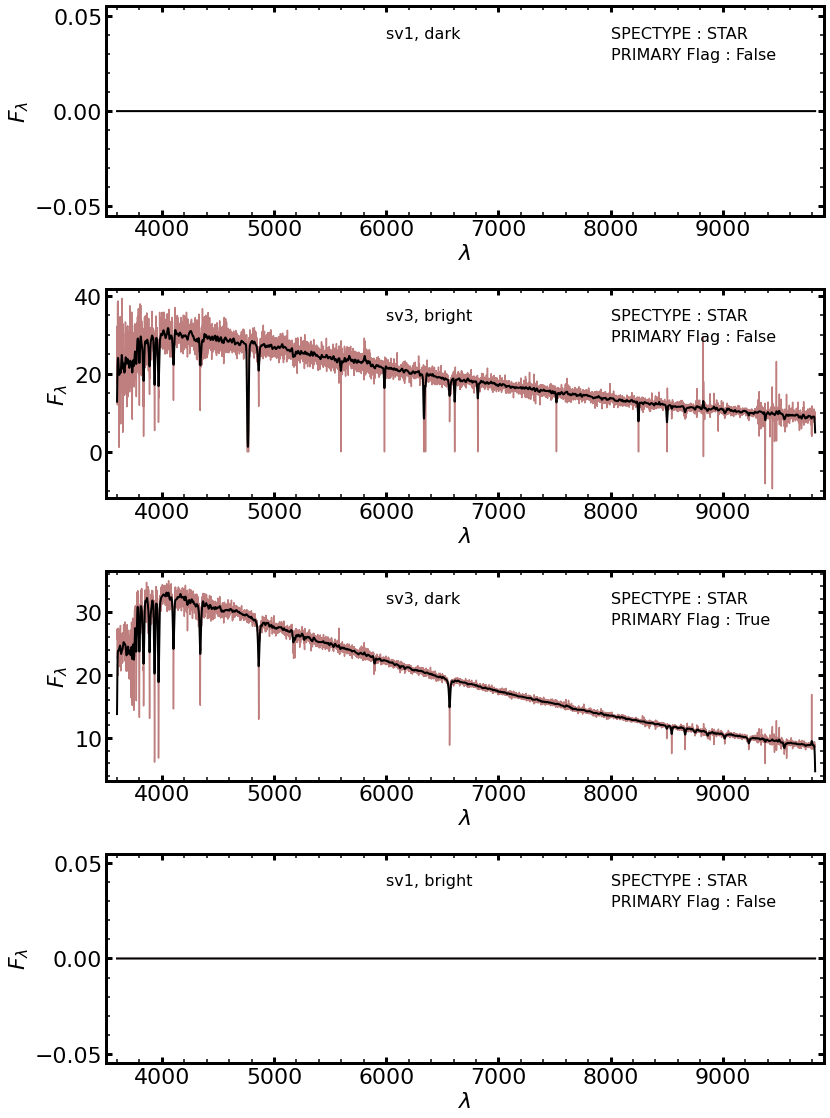

In [35]:
# Number of spectra 
n = len(records)

fig, ax = plt.subplots(n, 1, figsize = (12,(4*n)))

for jj in range(n):
    survey = records[jj].survey
    program = records[jj].program
    spectype = records[jj].spectype
    primary_flag = records[jj].specprimary

    lam = records[jj].wavelength
    flam = records[jj].flux
    
    # Plot the combined spectrum in maroon
    ax[jj].plot(lam, flam, color = 'maroon', alpha = 0.5)
    # Over-plotting smoothed spectra 
    ax[jj].plot(lam, convolve(flam, Gaussian1DKernel(5)), color = 'k', lw = 2.0)
    ax[jj].set(xlim = [3500, 9900], xlabel = '$\lambda$', ylabel = '$F_{\lambda}$')
    trans = ax[jj].get_xaxis_transform()
    ax[jj].annotate(f'{survey}, {program}', xy = (6000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'SPECTYPE : {spectype}', xy = (8000, 0.85), xycoords = trans, fontsize = 16)
    ax[jj].annotate(f'PRIMARY Flag : {primary_flag}', xy = (8000, 0.75), xycoords = trans, fontsize = 16)
    
plt.tight_layout()

From the above plot, we can see that the spectrum with PRIMARY Flag = True is the one with the highest signal-to-noise ratio. The other available spectrum is a bit noisy, compared to the "best" spectrum.
We see that the two SV1 records of this object show no spectra. Let us check their fiber status below.

In [36]:
print ('Coadd Fiberstatus of the SV1 Dark observation: ', records[0].coadd_fiberstatus)
print ('Coadd Fiberstatus of the SV1 Bright observation: ', records[3].coadd_fiberstatus)

Coadd Fiberstatus of the SV1 Dark observation:  512
Coadd Fiberstatus of the SV1 Bright observation:  512


The `coadd_fiberstatus` of the observations contains [information about the fiber conditions](https://desidatamodel.readthedocs.io/en/latest/bitmasks.html#spectroscopic-reduction-masks) during the spectra observations. `coadd_fiberstatus` = 512 indicates bad fiber conditions, resulting in no spectra (flux = 0 and ivar = 0). This shows the importance of accessing the "best" spectra for scientific analysis.

<a class="anchor" id="ref"></a>
# References

* DESI EDR Documentation: https://data.desi.lbl.gov/doc/
* DESI EDR at Astro Data Lab: https://datalab.noirlab.edu/desi/
* Information about SPARCL: https://astrosparcl.datalab.noirlab.edu/sparc/
* Datamodel information: https://desidatamodel.readthedocs.io/en/latest/
    * [tiles-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/tiles-SPECPROD.html)
    * [exposures-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/exposures-SPECPROD.html)
    * [Redshift catalogs](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/index.html)
    * [zall-pix-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-pix-SPECPROD.html)
    * [zall-tilecumulative-fuji.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zall-tilecumulative-SPECPROD.html)
    * [zpix-SURVEY-PROGRAM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [ztile-SURVEY-PROGRAM-GROUPTYPE.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/zcatalog/zpix-SURVEY-PROGRAM.html)
    * [coadd-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/coadd-SURVEY-PROGRAM-PIXNUM.html)
    * [redshift-SURVEY-PROGRAM-PIXNUM.fits](https://desidatamodel.readthedocs.io/en/latest/DESI_SPECTRO_REDUX/SPECPROD/healpix/SURVEY/PROGRAM/PIXGROUP/PIXNUM/redrock-SURVEY-PROGRAM-PIXNUM.html)
* Information about DESI bitmasks: https://desidatamodel.readthedocs.io/en/latest/bitmasks.html
* DESI Target Selection pipeline paper: [Myers et al. 2023](https://ui.adsabs.harvard.edu/abs/2023AJ....165...50M/abstract)
* Introduction to SPARCL notebook: https://github.com/astro-datalab/notebooks-latest/blob/master/04_HowTos/SPARCL/How_to_use_SPARCL.ipynb

# Acknowledgments

* DESI Data License and Acknowledgments: https://data.desi.lbl.gov/doc/acknowledgments/
* Astro Data Lab Acknowledgments: https://datalab.noirlab.edu/acknowledgements.php
* SPARCL Acknowledgments: https://astrosparcl.datalab.noirlab.edu/sparc/acknowledgments

---